### MDN Heteroscedastic Example ###

"We use the same network architecture: 1-hidden layer neural network with ReLU nonlinearity (Nair and Hinton, 2010), containing 50 hidden units for smaller datasets and 100 hidden units for the larger protein and Year Prediction MSD datasets"

"We trained for 40 epochs; we refer to (Herna ́ndez-Lobato and Adams, 2015) for further details about the datasets and the experimental protocol. We used 5 networks in our ensemble. Our results are shown in Table 1, along with the PBP and MC-dropout results reported in their respective papers"

"On some datasets, we observe that our method is slightly worse in terms of RMSE. We believe that this might be caused due to the het- eroscedastic regression training criterion, which optimises for NLL instead of MSE as discussed in the toy example in Figure 3."

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

/Users/ermanoarruda/virtualenvs/robotics/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.mdn import MDN

from aml_dl.gp.simple_gp import GaussianProcess, kernel

from IPython import display
import time

## Configs

In [5]:



adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': [100],#[20,20,10],
    'k_mixtures': 1,
    'write_summary': False,
    'load_saved_model': False,
#     'model_dir': check_point_dir + '/inv/',
#     'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
#     'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
    'adv_epsilon': 0.01,
    'reg_lambda': 0.01
}

In [6]:
tf.set_random_seed(42)
np.random.seed(seed=42)
sess = tf.InteractiveSession()

In [7]:
model = MDN(sess,network_params)
model.init_model()

In [8]:
noise_level = 1.0#0.1#0.00000001;
width = 1.0 # 0.5
scale = 30 # 30


gp = GaussianProcess(noise_level, width, scale, kernel)

## Prepare data

In [9]:
def fun_h(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return np.cos(2*t - 1/2)/2 + np.cos(t) + 1 + noise

def fun_poly(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return -0.01*(t ** 3) + np.square(t)*0.01 + noise

def fun_cubic_poly(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return 0.01*(t ** 3) + 0.01*noise

# *
def fun_s(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return (t-8) ** 3 - 5 * (t - 8)

def fun_c(t, noise_gain=0.0):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
        
    return t * np.cos(t) + noise

def fun_g(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    noise = noise_gain*np.random.randn(d1, d2)
    return np.divide(np.power(np.multiply((np.sin(t) - np.sin(2*t)/2 + np.sin(3*t)/3. - 
                                           np.sin(4*t)/4. + 4),t),2),(t+1)) + noise

def sawtoothxy(x,y):
    t, r = cart2pol(x,y) # change to polar coordinates
    h = fun_h(t)
    g = fun_g(r)
    f = np.multiply(g,h)
    return f


def f_heteroscedastic(X, std = 1.0):
    # target function is just a linear relationship + heteroscadastic noise
    return X + std*np.random.multivariate_normal(np.zeros(X.shape[0]),
                                                 np.diag(X**2), 1)[0]

func_y = f_heteroscedastic

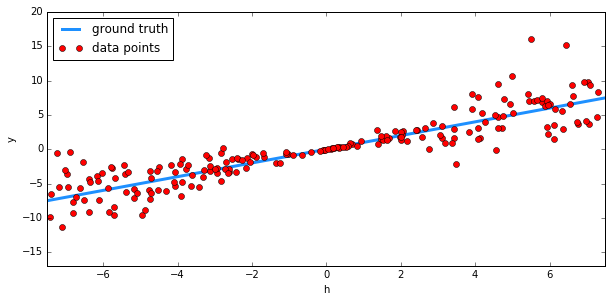

In [10]:
num_data_points = 200 # 1000
x_values = np.random.uniform(-7.5, 7.5, num_data_points)  # input data
y_values = func_y(x_values, 0.5)
x_true = np.linspace(-7.5,7.5, num_data_points)
y_true = x_true
x_test = x_true

train_idx = np.arange(num_data_points)#np.random.choice(np.arange(300,1650),20)

# plt.plot(x_values, y_values, 'dodgerblue', linewidth=3.0)
fig2 = plt.figure(1, figsize=(10,10))
ax2 = fig2.add_subplot(211)
plt.plot(x_test, y_true, 'dodgerblue', linewidth=3.0, label="ground truth")
plt.plot(x_values[train_idx], y_values[train_idx], 'ro', label="data points")

plt.xlabel("h")
plt.ylabel("y")
# print x_values[300:1450]
# print y_values[300:1450]

plt.xlim([-7.5,7.5])
plt.ylim([-17,20])
plt.legend(loc='upper left')

In [11]:
# x_train = np.vstack([x_values[200:400,None],x_values[750:1000,None],x_values[1250:1450,None]])
# y_train = np.vstack([y_values[200:400,None],y_values[750:1000,None],y_values[1250:1450,None]])

In [12]:
x_train = np.vstack([x_values[train_idx,None]])
y_train = np.vstack([y_values[train_idx,None]])

In [13]:
for idx in range(x_train.shape[0]):
    gp.update(x_train[idx,:], y_train[idx,:])

In [14]:
pred, cov, logp = gp.predict3(x_test)
std = np.diagonal(cov)

In [15]:
sample_posterior = gp.sample_multivariate(pred, cov, len(pred), 5)

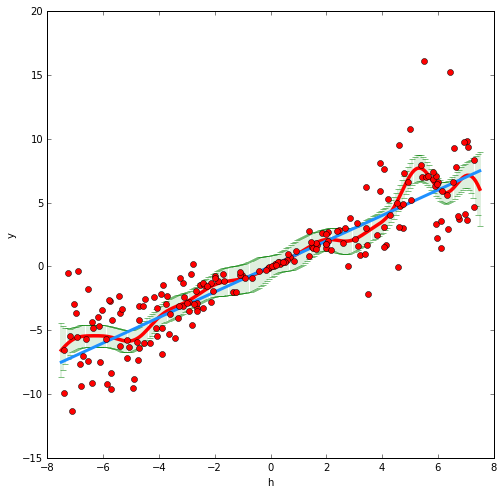

In [16]:
fig2 = plt.figure(2, figsize=(8,8))
plt.errorbar(x_test, pred, yerr=np.sqrt(std)*3.0, fmt='r-', ecolor='g', elinewidth=0.25, linewidth=3.5)
plt.plot(x_test, y_true, 'dodgerblue', linewidth=3.0)
# plt.plot(x_values, sample_posterior)
# plt.xlim([0,12])
# plt.ylim([-0,3.0])
plt.plot(gp.x, gp.y, 'ro')
plt.xlabel("h")
plt.ylabel("y")

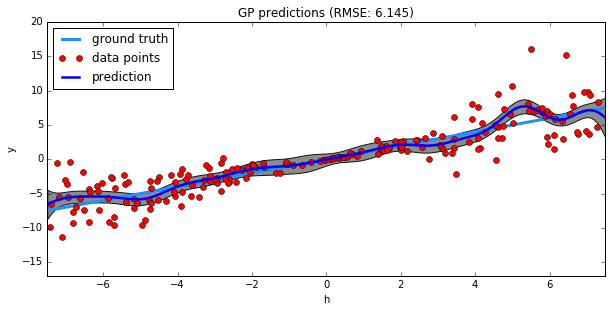

In [31]:
stddev = 3.0 #3.0
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211)
ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(pred,std)]
yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(pred,std)]

# ax.plot(x_true, y_true, color='r')
plt.plot(x_test, y_true, 'dodgerblue', linewidth=3.0, label="ground truth")

ax.fill_between(x_true.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
plt.plot(gp.x, gp.y, 'ro', label="data points")
plt.plot(x_test, pred, color='b', linewidth=2.5, label="prediction")
plt.xlabel("h")
plt.ylabel("y")

error = np.sqrt(np.mean(np.square(pred-y_true)))
plt.title("GP predictions (RMSE: %0.3f)"%(error,))

plt.xlim([-7.5,7.5])
plt.ylim([-17,20])
plt.legend(loc='upper left')

# ax2 = fig.add_subplot(212)

# ax2.plot(x_true, np.sqrt(std)*stddev, color='g')

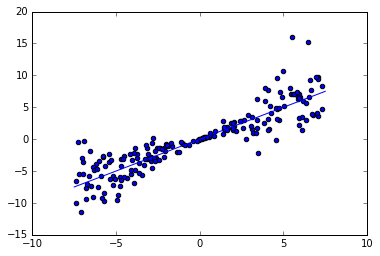

In [18]:
plt.figure()
plt.scatter(x_train,y_train)
plt.plot(x_true,y_true)
plt.show()

In [19]:
iterations = 1600

In [20]:

# for i in range(epochs):
#     loss = model.train(x_train, y_train, iterations)
    
#     mean_loss[i] = np.mean(loss)

loss = model.train(x_train, y_train, iterations)

#     fig, mloss = test_and_plot(i, loss)
#     mean_loss.append(np.mean(mloss))
#     ax2 = fig.add_subplot(414)
#     ax2.plot(mean_loss, 'r-')
    
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(0.001)
    
# ax = fig2.add_subplot(212)
#  ax.plot(np.arange(100, iterations,1), loss[0, 100:], 'r-')

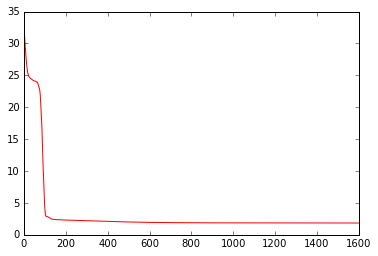

In [21]:
plt.plot(np.arange(0, iterations, 1), loss, 'r-')

## Test

In [22]:
x_test = x_true#np.linspace(0, 12, num_data_points)
y_test = y_values #fun_h(x_test, 0.0)

In [23]:
out_mus = model.run_op('mu', np.expand_dims(x_test,axis=1))
out_sigma = model.run_op('sigma', np.expand_dims(x_test,axis=1))
out_pis = model.run_op('pi', np.expand_dims(x_test,axis=1))

In [24]:
# print out_sigma


In [25]:
# out_mus = np.reshape(out_mus,(-1,1))
# out_sigma = np.reshape(out_sigma,(-1,1))
# out_pis = np.reshape(out_pis,(-1,1))

In [26]:
# print np.reshape(out_mus[0],(-1,1))
# print out_sigma.shape
# print out_pis.shape

In [27]:
mean_out, var_out = model.predict(np.expand_dims(x_test,axis=1))

In [28]:
# ? = np.array(var_out).ravel()
print mean_out.flatten().shape
print x_test.shape

(200,)
(200,)


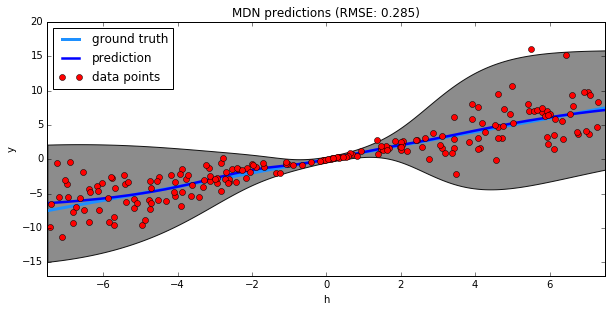

In [32]:
stddev = 3.0#1.9600 #3.0

fig2 = plt.figure(1, figsize=(10,10))

ax = fig2.add_subplot(211)

# plt.xlim([0,12])
# plt.ylim([-7.5,3.0])
plt.xlim([-7.5,7.5])
plt.ylim([-17,20])



ypl2 = [float(mu-stddev*np.sqrt(sig[0])) for mu,sig in zip(mean_out,var_out)]
yph2 = [float(mu+stddev*np.sqrt(sig[0])) for mu,sig in zip(mean_out,var_out)]


ax.plot(x_true, y_true, 'dodgerblue', linewidth=3.0, label="ground truth")


ax.fill_between(x_test.tolist(), ypl2, yph2, facecolor='grey', interpolate=True, alpha=0.9)

ax.plot(x_test.flatten(), mean_out.flatten(), color='b', linewidth=2.5, label="prediction")

colours = ['g','c','k','m','y']

# for k in range(network_params['n_ensembles']):
#     y_em = np.reshape(out_mus[k],(-1,))
#     ax.plot(x_test, y_em, color=(np.random.rand(),np.random.rand(),np.random.rand()),linewidth=0.5)

# plt.scatter(x_train,y_train)
ax.plot(x_train, y_train, 'ro', label="data points")

plt.xlabel("h")
plt.ylabel("y")

error = np.sqrt(np.mean(np.square(mean_out.flatten()-y_true)))
plt.title("MDN predictions (RMSE: %0.3f)"%(error,))
plt.legend(loc='upper left')

In [30]:
# std = [float(np.sqrt(sig[0])) for sig in var_out]
# plt.figure(3)
# ax2 = fig.add_subplot(212)

# plt.plot(x_test, std, color='g')

# plt.show()